In [72]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

['device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0',
 'device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0',
 'device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0',
 'device: 3, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0']

In [73]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Препроцессинг

In [74]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

## Загрузка изображений

In [77]:
images = []
diseases = []
for culture in glob("dataset/*"):
    for disease in glob(culture+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            diseases.append(culture.split('/')[-1]+"-"+disease.split('/')[-1])
            images.append(img)

images = np.array(images)
diseases = np.array(diseases)
images.shape, diseases.shape

((934, 224, 224, 3), (934,))

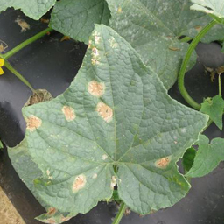

In [78]:
array_to_img(images[0])

## генерация аугментированных изображений

In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
X_train, X_test, C_train, C_test = train_test_split(preprocess_input(np.array(images)), diseases, train_size=0.8, test_size=0.2, random_state=777) # поменял на исходные изображения

In [80]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

de = LabelEncoder()
num_train_labels = de.fit_transform(C_train)
cat_train_labels = to_categorical(num_train_labels)

num_test_labels = de.fit_transform(C_test)
cat_test_labels = to_categorical(num_test_labels)

In [81]:
images_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True)

flow = images_gen.flow(X_train,cat_train_labels)

In [82]:
gen_count = 400
gen_images = []
gen_labels = []
for i in range(gen_count):
    x,y = flow.next()
    gen_images.append(x)
    gen_labels.append(y)
gen_images = np.concatenate(gen_images)
gen_labels = np.concatenate(gen_labels)

In [83]:
print(f"Сгенерировано {gen_images.shape[0]} изображений")

Сгенерировано 12464 изображений


## подготовка данных и разбиение выборки 

## Обучение

In [84]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Input, concatenate 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [85]:
labels_count = np.unique(num_test_labels).size
labels_count

25

In [90]:

restnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

output = restnet.layers[-1].output # используем выход пердыдущего слоя
restnet_output = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False

#C_input = Input(shape=(C.shape[1]))

conv = Conv2D(600, (5,5))(restnet_output.output)
res_pooling = MaxPooling2D((3,3))(conv)
flat = Flatten()(res_pooling)

#concat_l = concatenate([C_input, flat])

dense_1 = Dense(128, activation='sigmoid')(flat)
drop_1 = Dropout(0.3)(dense_1)
dense_3 = Dense(labels_count, activation='sigmoid')(drop_1)

model = Model(inputs=[restnet_output.input], outputs=[dense_3])
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

In [87]:
!nvidia-smi

Wed Mar  3 11:30:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   40C    P0    55W / 300W |  31150MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |    318MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [91]:
import datetime

history = model.fit(gen_images, gen_labels,
                    epochs=40,
                    steps_per_epoch=200,
                    validation_steps=30,
                    validation_data=(X_test, cat_test_labels),
                    verbose=1)

Epoch 1/40
200/200 [==============================] - 11s 53ms/step - loss: 2.4931 - accuracy: 0.5068 - val_loss: 2.3478 - val_accuracy: 0.6043
Epoch 2/40
200/200 [==============================] - 10s 49ms/step - loss: 2.1691 - accuracy: 0.7792 - val_loss: 2.2147 - val_accuracy: 0.6471
Epoch 3/40
200/200 [==============================] - 10s 48ms/step - loss: 1.9859 - accuracy: 0.8816 - val_loss: 2.1076 - val_accuracy: 0.6578
Epoch 4/40
200/200 [==============================] - 10s 48ms/step - loss: 1.8178 - accuracy: 0.9349 - val_loss: 1.9852 - val_accuracy: 0.7059
Epoch 5/40
200/200 [==============================] - 10s 49ms/step - loss: 1.6529 - accuracy: 0.9632 - val_loss: 1.8862 - val_accuracy: 0.7219
Epoch 6/40
200/200 [==============================] - 10s 48ms/step - loss: 1.4902 - accuracy: 0.9787 - val_loss: 1.7751 - val_accuracy: 0.7273
Epoch 7/40
200/200 [==============================] - 10s 49ms/step - loss: 1.3331 - accuracy: 0.9888 - val_loss: 1.6826 - val_accuracy:

200/200 [==============================] - 10s 48ms/step - loss: 0.3437 - accuracy: 0.9999 - val_loss: 1.1940 - val_accuracy: 0.7166
Epoch 18/40
200/200 [==============================] - 9s 47ms/step - loss: 0.2995 - accuracy: 1.0000 - val_loss: 1.1531 - val_accuracy: 0.7273
Epoch 19/40
200/200 [==============================] - 10s 48ms/step - loss: 0.2628 - accuracy: 1.0000 - val_loss: 1.1399 - val_accuracy: 0.7219
Epoch 20/40
200/200 [==============================] - 10s 48ms/step - loss: 0.2338 - accuracy: 1.0000 - val_loss: 1.1134 - val_accuracy: 0.7273
Epoch 21/40
200/200 [==============================] - 10s 48ms/step - loss: 0.2043 - accuracy: 1.0000 - val_loss: 1.1082 - val_accuracy: 0.7273
Epoch 22/40
200/200 [==============================] - 10s 48ms/step - loss: 0.1823 - accuracy: 1.0000 - val_loss: 1.1121 - val_accuracy: 0.7166
Epoch 23/40
200/200 [==============================] - 10s 49ms/step - loss: 0.1607 - accuracy: 1.0000 - val_loss: 1.0597 - val_accuracy: 0.738

200/200 [==============================] - 9s 47ms/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 1.0038 - val_accuracy: 0.7380
Epoch 35/40
200/200 [==============================] - 10s 48ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.9944 - val_accuracy: 0.7326
Epoch 36/40
200/200 [==============================] - 10s 48ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.9822 - val_accuracy: 0.7433
Epoch 37/40
200/200 [==============================] - 10s 48ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.9826 - val_accuracy: 0.7273
Epoch 38/40
200/200 [==============================] - 10s 48ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.9997 - val_accuracy: 0.7273
Epoch 39/40
200/200 [==============================] - 10s 48ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.9886 - val_accuracy: 0.7219
Epoch 40/40
120/200 [=================>............] - 6s 48ms/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.9786 - val_accuracy: 0.7273

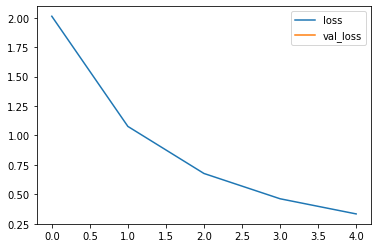

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

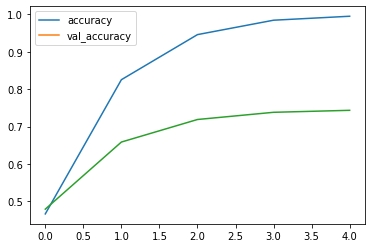

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot((np.array(history.history["val_accuracy"])+np.array(history.history["accuracy"]))/2)
plt.legend(["accuracy","val_accuracy"])

# Анализ результатов

In [26]:
def predict(n):
    img = preprocess_input(np.array([images[n]]))
    predicted = np.argmax(model.predict(img))
    plt.imshow(images[n].astype("int"))
    actual = np.argmax(D[n])
    return de.inverse_transform([predicted, actual])

In [31]:
def find_failed():
    transformed = preprocess_input(np.array(images))
    predicted = model.predict(transformed)
    for i in range(predicted.shape[0]):
        p = de.inverse_transform([np.argmax(predicted[i])])[0]
        a = diseases[i]
        if(p!=a):
            print((i,a,p))

In [32]:
print("id, predicted, actual")
find_failed()

id, predicted, actual
(1, 'Corn-Healthy', 'Wheat-Yellow rust')
(32, 'Corn-Healthy', 'Wheat-Healthy')
(36, 'Corn-Downy mildew', 'Corn-Healthy')
(37, 'Corn-Downy mildew', 'Corn-Healthy')
(38, 'Corn-Downy mildew', 'Wheat-Yellow rust')
(39, 'Corn-Downy mildew', 'Corn-Healthy')
(42, 'Corn-Downy mildew', 'Wheat-Yellow rust')
(43, 'Corn-Downy mildew', 'Corn-Northern leaf blight')
(44, 'Corn-Downy mildew', 'Corn-Northern leaf blight')
(48, 'Corn-Downy mildew', 'Corn-Healthy')
(53, 'Corn-Downy mildew', 'Corn-Healthy')
(56, 'Corn-Downy mildew', 'Wheat-Black chaff')
(63, 'Corn-Downy mildew', 'Corn-Eyespot')
(83, 'Corn-Northern leaf blight', 'Corn-Healthy')
(97, 'Corn-Northern leaf blight', 'Wheat-Black chaff')
(101, 'Corn-Eyespot', 'Corn-Southern rust')
(108, 'Corn-Eyespot', 'Wheat-Yellow rust')
(119, 'Corn-Eyespot', 'Corn-Southern rust')
(126, 'Corn-Eyespot', 'Corn-Healthy')
(127, 'Corn-Eyespot', 'Corn-Healthy')
(128, 'Corn-Eyespot', 'Corn-Northern leaf blight')
(145, 'Corn-Southern rust', 'Whea

In [33]:
def get_by_name(name):
    return list(filter(lambda x: x[1] == name, enumerate(diseases)))

In [34]:
get_by_name('Cotton-Healthy')[0][0]

333

In [35]:
def draw(id):
    plt.figure()
    plt.title(diseases[id])
    plt.imshow(images[id].astype("int")[:,:])

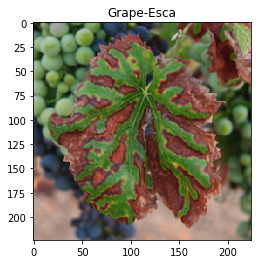

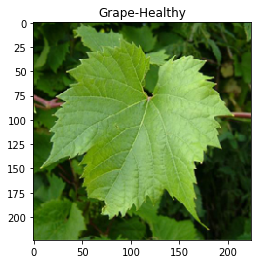

In [36]:
draw(get_by_name('Grape-Esca')[1][0])
draw(get_by_name('Grape-Healthy')[1][0])

In [37]:
pl1 = images[get_by_name('Grape-Esca')[1][0]].astype("int")

(<matplotlib.image.AxesImage at 0x7f82e636de50>,)

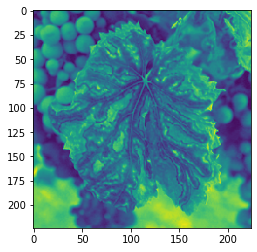

In [38]:
plt.imshow(pl1[:,:,0]),

In [39]:
yellow = pl1[:,:,1]-pl1[:,:,2]

In [40]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [42]:
def minmax(a):
    flat = yellow.reshape((yellow.size,1))
    return min_max_scaler.fit_transform(flat).reshape(yellow.shape)

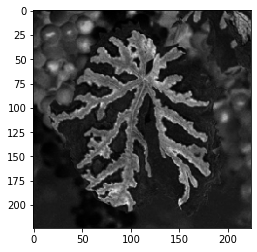

In [48]:
a = minmax(yellow)
plt.imshow(a*minmax(pl1[:,:,1]), cmap="gray")